In [ ]:
import kagglehub
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [ ]:
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [10]:
train_dir = os.path.join(path, "Training")
test_dir  = os.path.join(path, "Testing")

print(os.listdir(train_dir))


['pituitary', 'notumor', 'meningioma', 'glioma']


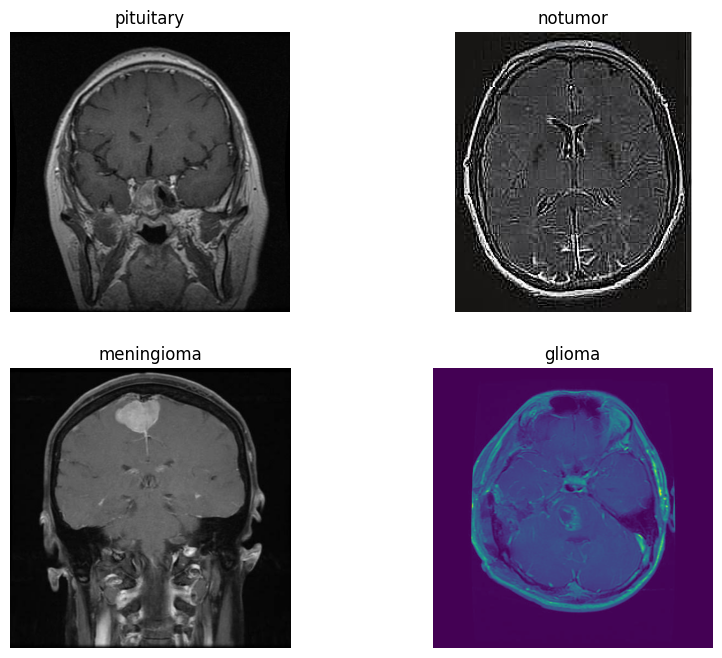

In [ ]:
classes = os.listdir(train_dir)

plt.figure(figsize=(10,8))
for i, cls in enumerate(classes):
    img_name = random.choice(os.listdir(os.path.join(train_dir, cls)))
    img_path = os.path.join(train_dir, cls, img_name)
    img = Image.open(img_path)

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()


In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2,
    # brightness_range=[0.8, 1.2]
)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [13]:
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 1311 images belonging to 4 classes.


In [15]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
base_model.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]


In [18]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    batch_size=32,
    callbacks=[callbacks],
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7166 - loss: 0.6987

143/143 ━━━━━━━━━━━━━━━━━━━━ 153s 875ms/step - accuracy: 0.7171 - loss: 0.6974 - val_accuracy: 0.7791 - val_loss: 0.5630 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8673 - loss: 0.3494

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 480ms/step - accuracy: 0.8673 - loss: 0.3494 - val_accuracy: 0.7932 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8911 - loss: 0.3069

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.8911 - loss: 0.3069 - val_accuracy: 0.8142 - val_loss: 0.4745 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8926 - loss: 0.2758

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.8927 - loss: 0.2758 - val_accuracy: 0.8379 - val_loss: 0.4211 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.9030 - loss: 0.2512 - val_accuracy: 0.8230 - val_loss: 0.4716 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.9035 - loss: 0.2586 - val_accuracy: 0.8195 - val_loss: 0.5086 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.9132 - loss: 0.2293 - val_accuracy: 0.8317 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9331 - loss: 0.1917

143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 478ms/step - accuracy: 0.9331 - loss: 0.1917 - val_accuracy: 0.8528 - val_loss: 0.3956 - learning_rate: 3.0000e-04
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 480ms/step - accuracy: 0.9360 - loss: 0.1869 - val_accuracy: 0.8624 - val_loss: 0.4174 - learning_rate: 3.0000e-04
Epoch 10/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.9370 - loss: 0.1687 - val_accuracy: 0.8493 - val_loss: 0.4036 - learning_rate: 3.0000e-04
Epoch 11/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.9438 - loss: 0.1588 - val_accuracy: 0.8589 - val_loss: 0.4103 - learning_rate: 3.0000e-04
Epoch 12/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 479ms/step - accuracy: 0.9388 - loss: 0.1664 - val_accuracy: 0.8580 - val_loss: 0.3989 - learning_rate: 9.0000e-05
Epoch 13/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9435 - loss: 0.1533

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.9435 - loss: 0.1533 - val_accuracy: 0.8642 - val_loss: 0.3870 - learning_rate: 9.0000e-05
Epoch 14/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9462 - loss: 0.1474

143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 478ms/step - accuracy: 0.9462 - loss: 0.1475 - val_accuracy: 0.8677 - val_loss: 0.3730 - learning_rate: 9.0000e-05
Epoch 15/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.9510 - loss: 0.1377 - val_accuracy: 0.8589 - val_loss: 0.3908 - learning_rate: 9.0000e-05
Epoch 16/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9481 - loss: 0.1410

143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 502ms/step - accuracy: 0.9481 - loss: 0.1410 - val_accuracy: 0.8650 - val_loss: 0.3680 - learning_rate: 9.0000e-05
Epoch 17/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9498 - loss: 0.1418

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 490ms/step - accuracy: 0.9497 - loss: 0.1418 - val_accuracy: 0.8773 - val_loss: 0.3425 - learning_rate: 9.0000e-05
Epoch 18/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 491ms/step - accuracy: 0.9516 - loss: 0.1373 - val_accuracy: 0.8642 - val_loss: 0.3716 - learning_rate: 9.0000e-05
Epoch 19/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 477ms/step - accuracy: 0.9428 - loss: 0.1448 - val_accuracy: 0.8598 - val_loss: 0.3798 - learning_rate: 9.0000e-05
Epoch 20/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9505 - loss: 0.1449 - val_accuracy: 0.8685 - val_loss: 0.3837 - learning_rate: 9.0000e-05
Epoch 21/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9535 - loss: 0.1305

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.9535 - loss: 0.1305 - val_accuracy: 0.8703 - val_loss: 0.3374 - learning_rate: 2.7000e-05
Epoch 22/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.9518 - loss: 0.1358 - val_accuracy: 0.8598 - val_loss: 0.3719 - learning_rate: 2.7000e-05
Epoch 23/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.9529 - loss: 0.1290 - val_accuracy: 0.8773 - val_loss: 0.3465 - learning_rate: 2.7000e-05
Epoch 24/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.9495 - loss: 0.1247 - val_accuracy: 0.8703 - val_loss: 0.3599 - learning_rate: 2.7000e-05
Epoch 25/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 473ms/step - accuracy: 0.9474 - loss: 0.1446 - val_accuracy: 0.8799 - val_loss: 0.3394 - learning_rate: 8.1000e-06
Epoch 26/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 479ms/step - accuracy: 0.9610 - loss: 0.1114 - val_accuracy: 0.8738 - val_loss: 0.3642 - learning_rate: 8.1000e-06


In [19]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [20]:
history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    batch_size=32,
    callbacks=[callbacks],
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 121s 662ms/step - accuracy: 0.8627 - loss: 0.3529 - val_accuracy: 0.8510 - val_loss: 0.4376 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 487ms/step - accuracy: 0.9324 - loss: 0.1913 - val_accuracy: 0.8624 - val_loss: 0.3856 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.9465 - loss: 0.1455 - val_accuracy: 0.8913 - val_loss: 0.3508 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9559 - loss: 0.1215

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 485ms/step - accuracy: 0.9559 - loss: 0.1215 - val_accuracy: 0.9071 - val_loss: 0.3008 - learning_rate: 1.0000e-04
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.9645 - loss: 0.1114 - val_accuracy: 0.9027 - val_loss: 0.3123 - learning_rate: 1.0000e-04
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9691 - loss: 0.0829

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 491ms/step - accuracy: 0.9691 - loss: 0.0829 - val_accuracy: 0.9036 - val_loss: 0.2904 - learning_rate: 1.0000e-04
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9734 - loss: 0.0800

143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 497ms/step - accuracy: 0.9734 - loss: 0.0800 - val_accuracy: 0.9010 - val_loss: 0.2819 - learning_rate: 1.0000e-04
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 476ms/step - accuracy: 0.9748 - loss: 0.0704 - val_accuracy: 0.9062 - val_loss: 0.2990 - learning_rate: 1.0000e-04
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.9777 - loss: 0.0604 - val_accuracy: 0.9115 - val_loss: 0.3000 - learning_rate: 1.0000e-04
Epoch 10/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9791 - loss: 0.0566

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.9791 - loss: 0.0566 - val_accuracy: 0.9150 - val_loss: 0.2794 - learning_rate: 1.0000e-04
Epoch 11/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9834 - loss: 0.0458

143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - accuracy: 0.9834 - loss: 0.0459 - val_accuracy: 0.9281 - val_loss: 0.2693 - learning_rate: 1.0000e-04
Epoch 12/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 479ms/step - accuracy: 0.9878 - loss: 0.0423 - val_accuracy: 0.9080 - val_loss: 0.3200 - learning_rate: 1.0000e-04
Epoch 13/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.9864 - loss: 0.0423 - val_accuracy: 0.9124 - val_loss: 0.3409 - learning_rate: 1.0000e-04
Epoch 14/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9832 - loss: 0.0488

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 487ms/step - accuracy: 0.9831 - loss: 0.0488 - val_accuracy: 0.9264 - val_loss: 0.2621 - learning_rate: 1.0000e-04
Epoch 15/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.9894 - loss: 0.0333 - val_accuracy: 0.9273 - val_loss: 0.2775 - learning_rate: 1.0000e-04
Epoch 16/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.9859 - loss: 0.0424 - val_accuracy: 0.9185 - val_loss: 0.2889 - learning_rate: 1.0000e-04
Epoch 17/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.9857 - loss: 0.0350 - val_accuracy: 0.9316 - val_loss: 0.2827 - learning_rate: 1.0000e-04
Epoch 18/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9926 - loss: 0.0217

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.9927 - loss: 0.0217 - val_accuracy: 0.9343 - val_loss: 0.2513 - learning_rate: 3.0000e-05
Epoch 19/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 477ms/step - accuracy: 0.9912 - loss: 0.0254 - val_accuracy: 0.9334 - val_loss: 0.2675 - learning_rate: 3.0000e-05
Epoch 20/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9917 - loss: 0.0240

143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 493ms/step - accuracy: 0.9917 - loss: 0.0240 - val_accuracy: 0.9395 - val_loss: 0.2394 - learning_rate: 3.0000e-05
Epoch 21/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.9892 - loss: 0.0311 - val_accuracy: 0.9325 - val_loss: 0.2497 - learning_rate: 3.0000e-05
Epoch 22/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.9925 - loss: 0.0221 - val_accuracy: 0.9299 - val_loss: 0.2732 - learning_rate: 3.0000e-05
Epoch 23/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 478ms/step - accuracy: 0.9913 - loss: 0.0220 - val_accuracy: 0.9334 - val_loss: 0.2684 - learning_rate: 3.0000e-05
Epoch 24/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 488ms/step - accuracy: 0.9940 - loss: 0.0212 - val_accuracy: 0.9395 - val_loss: 0.2593 - learning_rate: 9.0000e-06
Epoch 25/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.9946 - loss: 0.0172 - val_accuracy: 0.9316 - val_loss: 0.2775 - learning_rate: 9.0000e-06


In [ ]:
y_pred = model.predict(test_data)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(
    test_data.classes,
    y_pred_classes,
    target_names=test_data.class_indices.keys()
))


41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 524ms/step
              precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       300
  meningioma       0.95      0.91      0.93       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.94      1.00      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



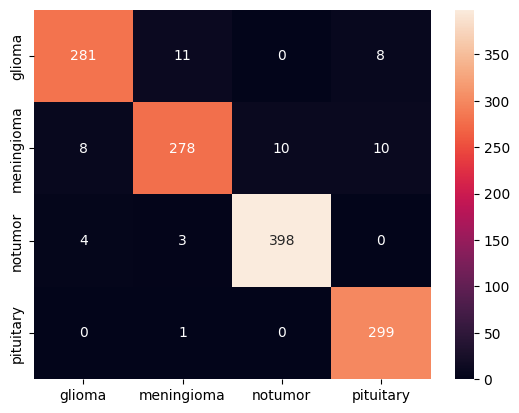

In [ ]:
cm = confusion_matrix(test_data.classes, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.show()


In [ ]:
y_true = tf.keras.utils.to_categorical(test_data.classes, 4)
auc = roc_auc_score(y_true, y_pred, multi_class="ovr")
print("ROC-AUC:", auc)


ROC-AUC: 0.9970976887426378


In [ ]:
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    heatmap = tf.reduce_sum(conv_outputs[0] * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


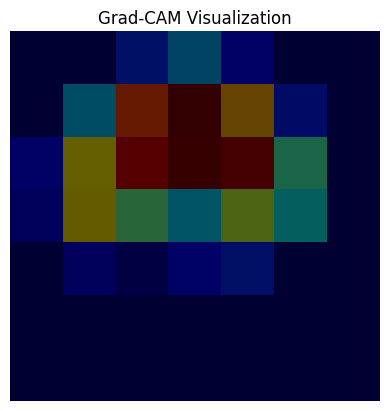

In [26]:
img, _ = test_data[0]
heatmap = grad_cam(model, img[:1], "top_conv")

plt.imshow(img[0])
plt.imshow(heatmap, cmap="jet", alpha=0.4)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


In [ ]:
img_path = test_data.filepaths[idx]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224,224))


In [30]:
heatmap_resized = cv2.resize(heatmap, (224,224))
heatmap_color = cv2.applyColorMap(
    np.uint8(255 * heatmap_resized),
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(img_resized, 0.6, heatmap_color, 0.4, 0)


In [31]:
# Get most activated area
h, w = heatmap_resized.shape
max_loc = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)

x, y = max_loc[1], max_loc[0]
size = 40

x1, y1 = max(0, x-size), max(0, y-size)
x2, y2 = min(w, x+size), min(h, y+size)

zoom = img_resized[y1:y2, x1:x2]


NameError: name 'class_names' is not defined

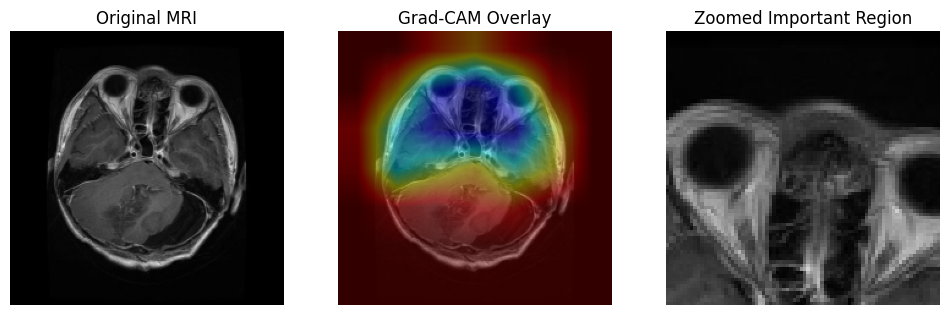

In [34]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.imshow(img_resized)
plt.title("Original MRI")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(zoom)
plt.title("Zoomed Important Region")
plt.axis("off")

conf = np.max(y_pred[idx])
pred_class = class_names[y_pred_classes[idx]]

plt.suptitle(f"Predicted: {pred_class} ({conf:.2f})", fontsize=14)

plt.suptitle("Model Decision Explanation")
plt.show()
